In [2]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qr_methods import generateGaussData, runQR, findAddShiftForCoverage

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
### Compute coverage of the additive adjustment c for all values c in CGrid
def oneCovOverC(nTrain, nTest, d, alpha, CGrid, lamb=0, verbose=False):
    
    XTrain, YTrain, XTest, YTest, _ = generateGaussData(nTrain, nTest, d)

    res = pd.DataFrame({})
    for c in CGrid:
        _, betaCAdj, _ = runQR(XTrain,YTrain - c,alpha,lamb=lamb,intercept=False)
        covCAdj = np.mean(YTest <= c + XTest@betaCAdj)
        res = pd.concat([res,pd.DataFrame({'c': [c], 'Coverage': [covCAdj], 'Dimension': [d]})])

    return res

nTrials = 100
nTrain = 200
nTest = 2000
ds = [80]
alpha = 0.1
lamb = 0
CGrid = np.linspace(0,15,16)

resCovOverC = pd.DataFrame()
for i in tqdm(range(nTrials)):
    for d in ds:
        resCovOverC = pd.concat([resCovOverC, oneCovOverC(nTrain, nTest, d, alpha, CGrid, lamb)])
        

100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


In [5]:
### Evaluate coverage of the additive adjustment procedure with no regularization
def oneCAdjExperiment(nTrain, nTest, d, alpha, minC=-10, maxC=10, verbose=False):   
    covTolerance = 1/nTrain
    
    XTrain, YTrain, XTest, YTest, _ = generateGaussData(nTrain, nTest, d)

    ### Tuning C
    cAdj = findAddShiftForCoverage(XTrain,YTrain,alpha,minC,maxC)
    if verbose:
        print('Adjusted C: ', cAdj, ' Parameters: ', XTrain.shape)
    _, betaCAdj, _ = runQR(XTrain,YTrain - cAdj,alpha,intercept=False)
    covCAdj = np.mean(YTest <= cAdj + XTest@betaCAdj)
    accCAdj = np.sqrt(sum((betastar - betaCAdj)**2))

    res = pd.DataFrame({'Number of Training Points' : [nTrain],
                        'Dimension': [d],
                        'Coverage': [covCAdj],
                        'Accuracy': [accCAdj],
                        'Method': ['Additive Adjustment'],
                        'Selected Params': [cAdj]
                       })
    return res

nTrials = 100
nTrain = 200
nTest = 2000
ds = [1,20,40,60,80]
minC = -10
maxC = 10
alpha = 0.1


resCAdj = pd.DataFrame()
for i in tqdm(range(nTrials)):
    for d in ds:
        resCAdj = pd.concat([resCAdj, oneCAdjExperiment(nTrain, nTest, d, alpha, minC, maxC, minlamb, maxlamb, numlamb, verbose=False)])
        

100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


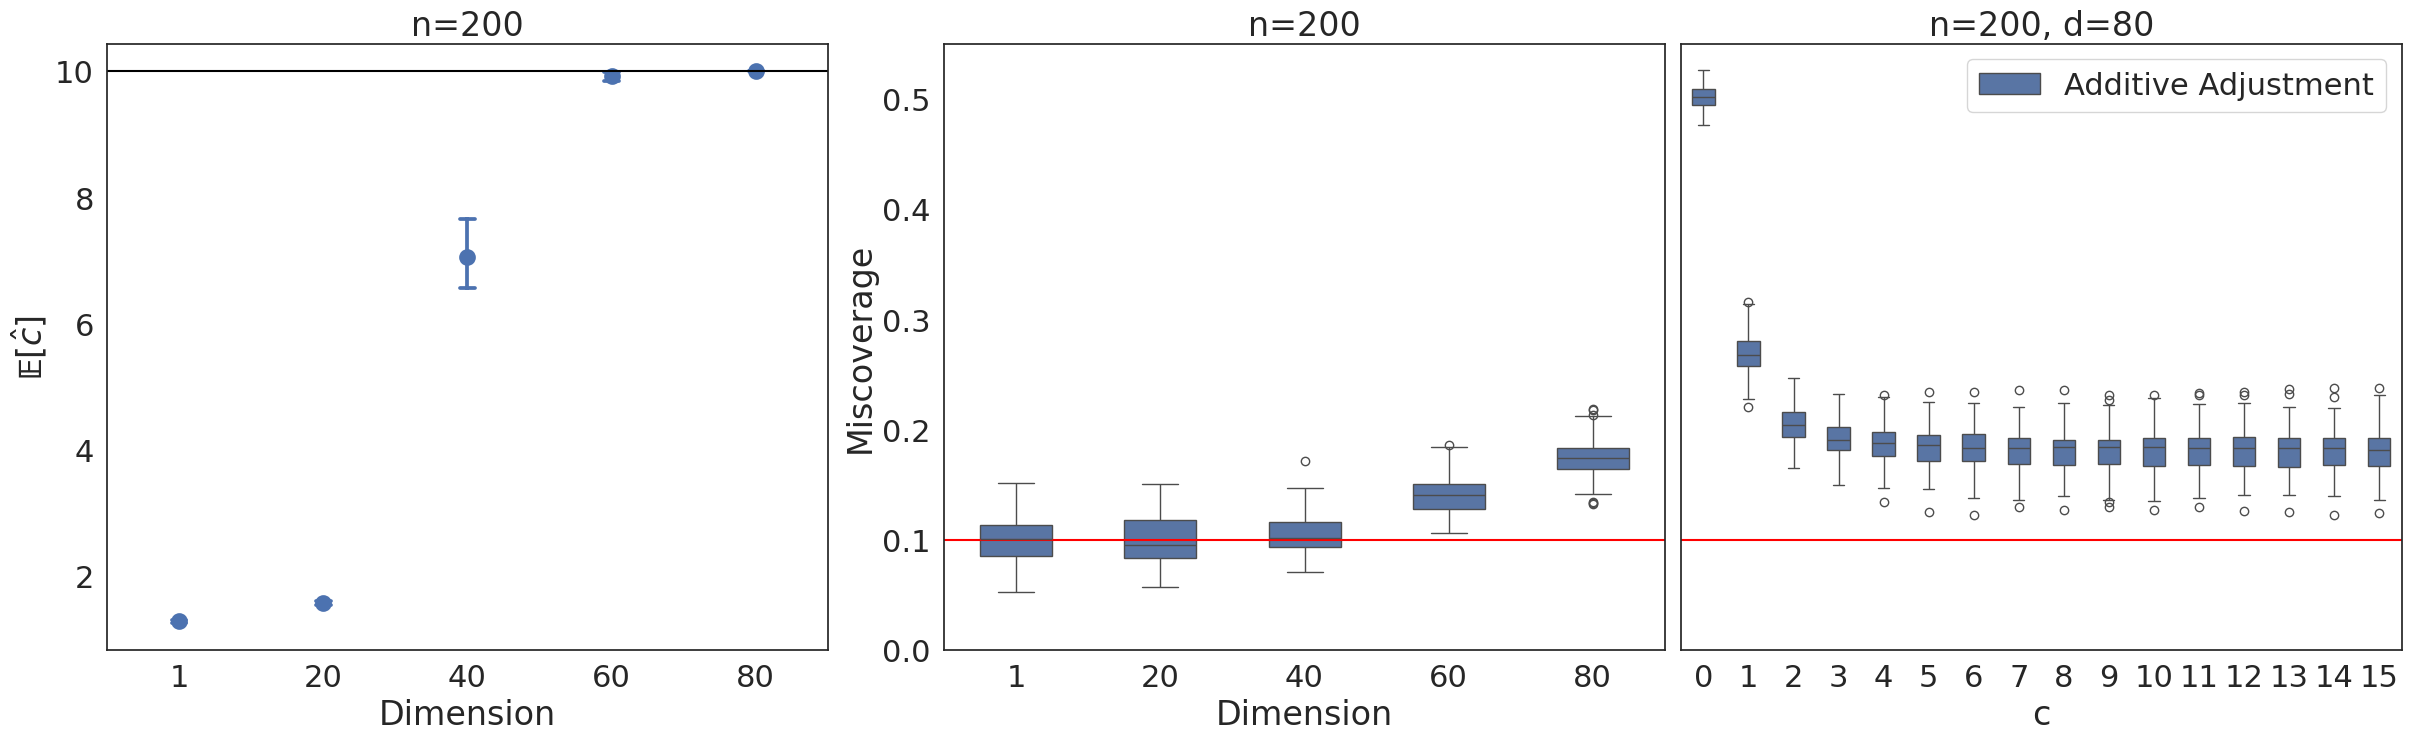

In [10]:
### Plot results
sns.set(rc={'figure.figsize':(24,7.3)})
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure(constrained_layout=True)

resCAdj['Miscoverage'] = 1-resCAdj['Coverage']
resCovOverC['c'] = resCovOverC['c'].astype(int)

ax1 = fig.add_subplot(1,3,1)
f1 = sns.pointplot(resCAdj[resCAdj['Method'] == 'Additive Adjustment'],x='Dimension',y='Selected Params',
    marker='o',
    linestyle='none',
    errorbar=('ci', 95),
    markersize=10,
    capsize=0.1,
    ax = ax1,
    hue = 'Method'
)
f1.axhline(maxC, color='black')
ax1.set_ylabel(r"$\mathbf{\mathbb{E}}[\hat{c}]$")
ax1.get_legend().set_title('')
ax1.set_title('n=200')

ax2 = fig.add_subplot(1,3,2)
f2 = sns.boxplot(resCAdj[resCAdj['Method'] == 'Additive Adjustment'],x='Dimension',y='Miscoverage',
                 hue='Method',ax=ax2,width=0.5)
f2.axhline(alpha, color='red')
ax2.get_legend().set_title('')
ax2.set_title('n=200')

resCovOverC['Miscoverage'] = 1-resCovOverC['Coverage']
resCovOverC['Method'] = 'Additive Adjustment'
ax3 = fig.add_subplot(1,3,3)
f3 = sns.boxplot(resCovOverC,x='c',y='Miscoverage',hue='Method',ax = ax3, width=0.5)
f3.axhline(alpha, color='red')
ax3.get_legend().set_title('')
ax3.set_title('n=200, d=80')

ax2.set_ylim(0,0.55)

ax1.legend_.remove()
ax2.legend_.remove()
ax3.sharey(ax2)
ax3.tick_params(left=False)
ax3.set_ylabel('')
ax3.yaxis.set_tick_params(labelleft=False)
ax3.yaxis.set_visible(False)


plt.savefig("figures/CAdjustment.pdf",bbox_inches='tight')